# Building an NMF Model

In [1]:
from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
import feather

Load in `reviews` and `beer-info` feather files, then merge them to produce a review database called `review_db` containing beer names, the user_id of the reviewer, and the score the user gave the beer.

In [2]:
reviews = feather.read_dataframe('../data/reviews-merged.feather')
beer_info = feather.read_dataframe('../data/beer-info-merged.feather')
review_db = reviews.merge(beer_info[['id','name']], left_on='beer_id', right_on='id')[['name','user_id','rating']]
review_db.head()

,name,user_id,rating
0,Surf Wax DIPA,Vasen_pakki,3.75
1,Surf Wax DIPA,Dave-Hill,3.50
2,Surf Wax DIPA,jsapas,3.75
3,Surf Wax DIPA,vanatyhi1,3.25
4,Surf Wax DIPA,stennibal,3.75


Convert the "tidy" `review_db` into a sparse matrix of `ratings` by pivoting on name and user_id, with intersections of reviewer/product interactions populated by the score that was given. Fill all missing values with zeroes. 

In [3]:
ratings = review_db.pivot_table(index='name', columns='user_id', values='rating', fill_value=0)
print(f'ratings is an M x N matrix, where M={ratings.shape[0]} and N={ratings.shape[1]}')
ratings.head()

ratings is an M x N matrix, where M=1913 and N=211106


user_id,--------,--JFG--,-1X,-7,-Alix-,-Awesnap-,-Beer,-C-,-Chris-,-ChrisB-,...,zzandman,zzavilla,zziemba09,zzinka,zzrascal,zzzbullseye,zzzigga,zzzirk,zzzzbeer,zzzzbeerzzzz
name,,,,,,,,,,,,,,,,,,,,,
(512) TWO,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,0.0,0,0,0,0,0,0.0,0,0,0.0
(New) English Bulldog Hazy IPA,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,0.0,0,0,0,0,0,0.0,0,0,0.0
(SIPAS) Hazy Session IPA,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,0.0,0,0,0,0,0,0.0,0,0,0.0
01 18 Off-Tempo DIPA,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,0.0,0,0,0,0,0,0.0,0,0,0.0
04609 Double IPA,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0,...,0.0,0,0,0,0,0,0.0,0,0,0.0


Words about SVD

In [4]:
%%time
s = np.linalg.svd(ratings, compute_uv=False)

CPU times: user 21min 28s, sys: 2min 7s, total: 23min 35s
Wall time: 2min 12s


Words about picking k

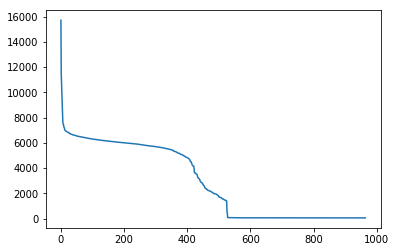

In [5]:
%matplotlib inline
pd.Series(s).iloc[:965].plot()

Select the number of components, k, and initialize the model. Fit and transform the model with the sparse matrix.

In [6]:
%%time
k = 6
model = NMF(n_components=k)
nmf_features = model.fit_transform(ratings)

CPU times: user 3min 19s, sys: 26.2 s, total: 3min 45s
Wall time: 36.8 s


The result of fitting and transforming the model will be the `beer_feat` table, containing one row for each beer and one column for each latent variable. 

In [7]:
beer_feat = pd.DataFrame(nmf_features, index=ratings.index)
print(f'beer_feat is an M x k matrix, where M={beer_feat.shape[0]} and k={beer_feat.shape[1]}')
beer_feat.head()

beer_feat is an M x k matrix, where M=1913 and k=6


,0,1,2,3,4,5
name,,,,,,
(512) TWO,0.000066,0.000167,0.001313,0.000039,0.000065,0.002611
(New) English Bulldog Hazy IPA,0.001837,0.002320,0.076518,0.000265,0.000616,0.009735
(SIPAS) Hazy Session IPA,0.001980,0.000039,0.000005,0.000000,0.000000,0.000213
01 18 Off-Tempo DIPA,0.000000,0.000006,0.000039,0.024840,0.000651,0.000821
04609 Double IPA,0.001308,0.000791,0.000164,0.000010,0.000033,0.001284


The components will be `user_feat` table, containing one column for each user and one row for each latent variable.

In [8]:
user_feat = pd.DataFrame(model.components_, columns=ratings.columns)
print(f'beer_feat is a k x N matrix, where k={user_feat.shape[0]} and N={user_feat.shape[1]}')
user_feat.head()

beer_feat is a k x N matrix, where k=6 and N=211106


user_id,--------,--JFG--,-1X,-7,-Alix-,-Awesnap-,-Beer,-C-,-Chris-,-ChrisB-,...,zzandman,zzavilla,zziemba09,zzinka,zzrascal,zzzbullseye,zzzigga,zzzirk,zzzzbeer,zzzzbeerzzzz
0,5.037626e-07,5.165801e-07,0.029883,9.381781e-09,2.175539e-09,0.000556,0.000000,0.002883,0.002160,0.000000,...,1.128940e-08,4.131382e-07,0.004824,0.000000,0.009002,0.003242,0.001085,5.106371e-09,2.961521e-06,2.325626e-07
1,2.249102e-08,2.069658e-07,0.000000,1.471127e-08,5.945652e-09,0.001583,0.000000,0.000528,0.000000,0.006652,...,1.729344e-08,1.501517e-08,0.011576,0.004733,0.005548,0.000190,0.058537,3.838116e-10,3.348250e-07,5.287057e-08
2,1.032525e-06,6.314880e-05,0.000000,4.192590e-07,9.696397e-09,0.000244,0.107278,0.000741,0.000079,0.028541,...,5.388189e-07,8.209628e-08,0.000486,0.000000,0.000747,0.000000,0.015203,8.922718e-09,6.902964e-07,1.226333e-07
3,2.640602e-09,8.267393e-08,0.000000,1.427753e-08,7.777353e-07,0.000129,0.000000,0.127782,0.005698,0.000008,...,4.049823e-07,4.137118e-08,0.000000,0.000000,0.038309,0.000000,0.009013,1.300729e-06,8.163857e-10,2.945679e-06
4,1.984842e-08,5.035605e-07,0.000000,2.930446e-08,3.014412e-08,0.000159,0.000000,0.045329,0.032030,0.000043,...,8.282233e-07,3.669142e-08,0.000227,0.717474,0.023304,0.000000,0.000945,3.558366e-08,2.945990e-08,1.291444e-09


Since `beer_feat` is M x k and `user_feat` is k x N, the dot product of the matrices will be M x N, producing a predictive matrix of `ratings` called `predictions`.

In [9]:
predictions = beer_feat.dot(user_feat).apply(lambda x: 0.25 * np.round(x/0.25))
predictions.head()

user_id,--------,--JFG--,-1X,-7,-Alix-,-Awesnap-,-Beer,-C-,-Chris-,-ChrisB-,...,zzandman,zzavilla,zziemba09,zzinka,zzrascal,zzzbullseye,zzzigga,zzzirk,zzzzbeer,zzzzbeerzzzz
name,,,,,,,,,,,,,,,,,,,,,
(512) TWO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(New) English Bulldog Hazy IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(SIPAS) Hazy Session IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01 18 Off-Tempo DIPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04609 Double IPA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
predictions.LetThereBeR0ck.describe()

count    1913.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: LetThereBeR0ck, dtype: float64

In [11]:
ratings.LetThereBeR0ck.describe()

count    1913.000000
mean        0.004574
std         0.141481
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.500000
Name: LetThereBeR0ck, dtype: float64